# On modelling optimization problems via Julia JuMP

## Prof. Mayron César O. Moreira 

**Universidade Federal de Lavras (UFLA)**  
**Department of Computer Science**  
**Lavras, Minas Gerais, Brazil**  

*Università degli Studi di Modena e Reggio Emilia (UNIMORE)*  
*Reggio Emilia, Italy*

## Minimum Tool Switching Problem (MTSP) 

The appropriate management of flexible manufacturing machines has impacts to the productivity levels. In this notebook, we deal with the Minimum Tool Switching Problem (MTSP). For recent advances conerning the MTSP, we suggest the article proposed by Calmels (2018).

We are given $n$ jobs and $m$ machines. Define by $J_t \in \{1,...,n\}$ the set of jobs requiring the tool $t$, and $T_j \in \{1,...,m\}$ the set of tools needed to process the job $j$. A single machine with capacity $C \ge \max_{j=1,...,n}{|T_j|}$ must execute all jobs in a sequence. We assume that the machine is not interrupted during the processing of a job. Since in most practical situations we do not have a magazine that holds all tools at once, the order that jobs are sequenced can increase the number of tool switches.

Our goal is to find the best job sequence in a single manufacturing machine such that we minimize the total number of tool switches performed overall pair of jobs, respecting machine capacity and assuring that when $j$ is executed, each tool in $T_j$ must be in the magazine. The figure below (source: [Moreira (2016)](http://www.teses.usp.br/teses/disponiveis/55/55134/tde-06012017-104534/en.php)) illustrates a solution of this problem, where $T=\{A,B,C,D,E,F,G,H\}$, $C = 5$, $n=5$, and:

* $T_1 = \{A,B,C\}$;
* $T_2 = \{A,C,D,E,F\}$;
* $T_3 = \{A,E\}$;
* $T_4 = \{B,C,G\}$;
* $T_5 = \{D,E,F,G,H\}$.

The number of tool switches is 6.

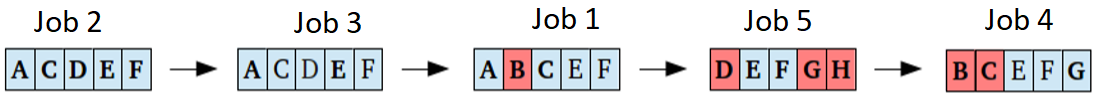

In [13]:
display("image/png", read("images/mtsp1.png"))

* **Reading data**

In [14]:
include("codes/instanceMTSP.jl")

fileInstance = "instances/mtsp/groupA-L1-1.txt"

# Reading instance
io = open(fileInstance)
instance = readMTSP(io)
;

* **Parameters (Sets and constants)**

In [15]:
n = instance.n
m = instance.m
J = instance.J
T = instance.T
C = instance.C
;

### MTSP: mathematical formulation (Tang \& Denardo, 1988)

* **Creating model**

In [16]:
using JuMP, Cbc
model = Model(with_optimizer(Cbc.Optimizer, seconds=60))
;

* **Variables** 
    * $w_{jk} \in \{0,1\}$: binary variable equal to 1 if job $j$ is the $k^{th}$ job in the sequence;
    * $y_{kt} \in \{0,1\}$: binary variable equal to 1 if tool $t$ is allocated in the magazine when processing the $k^{th}$ job in the sequence;
    * $z_{kt} \in \{0,1\}$: binary variable equal to 1 if tool $t$ is in the magazine during the processing of the $k^{th}$, but was not in the magazine in the processing of the $(k-1)^{th}$ job.

In [17]:
@variable(model, w[1:n,1:n], Bin)
@variable(model, y[1:n,1:m], Bin)
@variable(model, z[1:n,1:m], Bin)
;

* **Objective function**: minimize the number of tool switches.

\begin{equation}
\min \sum_{k=2}^{n} \sum_{t=1}^{m} z_{kt}
\end{equation}

In [18]:
@objective(model, Min, sum(z[k,t] for k=2:n, t=1:m))
;

* **Constraints 1 and 2**: establish job assignment.

\begin{equation}
\sum_{j=1}^n w_{jk} = 1 \quad k=1,...,n
\end{equation}

\begin{equation}
\sum_{k=1}^n w_{jk} = 1 \quad j=1,...,n
\end{equation}

In [19]:
@constraint(model, [k=1:n], sum(w[j,k] for j=1:n) == 1)
@constraint(model, [j=1:n], sum(w[j,k] for k=1:n) == 1)
;

* **Constraint 3**: Coupling constraints between variables $w$ and $y$.

\begin{equation}
\sum_{j \in J_t} w_{jk} \le y_{kt} \quad k=1,...,n, t=1,...,m
\end{equation}

In [20]:
@constraint(model, [k=1:n,t=1:m], sum(w[j,k] for j in J[t]) <= y[k,t])
;

* **Constraint 4**: magazine capacity.

\begin{equation}
\sum_{t=1}^m y_{kt} \le C \quad k=1,...,n
\end{equation}

In [21]:
@constraint(model, [k=1:n], sum(y[k,t] for t=1:m) <= C)
;

* **Constraint 5**: counts the number of tool switches.

\begin{equation}
y_{kt} - y_{(k-1)t} \le z_{kt} \quad k=2,...,n, t=1,...,m
\end{equation}

In [22]:
@constraint(model, [k=2:n,t=1:m], y[k,t] - y[k-1,t] <= z[k,t])
;

* **Optimizing**

In [23]:
optimize!(model)
;

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -seconds 60 -solve -quit (default strategy 1)
seconds was changed from 1e+100 to 60
Continuous objective value is 0 - 0.01 seconds
Cgl0004I processed model has 277 rows, 457 columns (457 integer (457 of which binary)) and 1521 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 227 integers unsatisfied sum - 46.9135
Cbc0038I Pass   1: suminf.   43.55385 (222) obj. 0.538462 iterations 153
Cbc0038I Pass   2: suminf.   41.17363 (234) obj. 0.741758 iterations 82
Cbc0038I Pass   3: suminf.   39.37662 (216) obj. 1.44805 iterations 70
Cbc0038I Pass   4: suminf.   38.81469 (208) obj. 1.81469 iterations 24
Cbc0038I Pass   5: suminf.   31.20058 (178) obj. 3.31247 iterations 102
Cbc0038I Pass   6: suminf.   31.20058 (178) obj. 3.31247 iterations 1
Cbc0038I Pass   7: suminf.   23.28333 (78) obj. 5.41667 iterations 118
Cbc0038I Pass   8: suminf.   22.45000 (74) obj.

*  **Printing the results**

In [24]:
println("Tools of the magazine, according to the sequence")
for k=1:n
    for j=1:n
        if(value(w[j,k]) >= 0.9)
            print("Job ", j, ": ")
            for t=1:m
                if(value(y[k,t]) >= 0.9)
                    print(t, " ")
                end
            end
            println()
        end
    end
end

Tools of the magazine, according to the sequence
Job 13: 1 2 5 6 8 
Job 12: 1 2 5 6 8 
Job 5: 1 2 3 5 6 
Job 8: 1 2 3 5 6 
Job 15: 1 3 5 6 
Job 10: 1 3 5 6 7 
Job 7: 1 5 6 7 
Job 3: 1 4 5 6 7 
Job 6: 1 4 5 6 7 
Job 1: 1 2 4 6 7 
Job 9: 1 2 4 6 7 
Job 4: 1 2 4 6 7 
Job 14: 1 4 6 7 
Job 11: 1 4 6 7 
Job 2: 4 6 


## References

Calmels, D. (2018). The job sequencing and tool switching problem: state-of-the-art literature review, classification, and trends. International Journal of Production Research, 1-21.

Moreira, A. C. B. (2016). O problema de minimização de trocas de ferramentas (Doctoral dissertation, Universidade de São Paulo).

Tang, C. S., & Denardo, R. V. (1988). Models arising from a flexible manufacturing machine, part I: minimization of the number of tool switches. Operations Research, 36(5), 767-777.

Tang, C. S., & Denardo, R. V. (1988). Models arising from a flexible manufacturing machine, part II: minimization of the number of switching instants. Operations Research, 36(5), 778-784.